## 2a. Dataset Introduction
The CIFAR-10 dataset consists of 60,000 32x32 colour images divided into 10 different classes. There are 50,000 training images and 10,000 test images. The classes are:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

Each image is a low-resolution (32x32 pixels) RGB image, making it a good dataset for building and testing a PyTorch model.


In [71]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [72]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                       shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


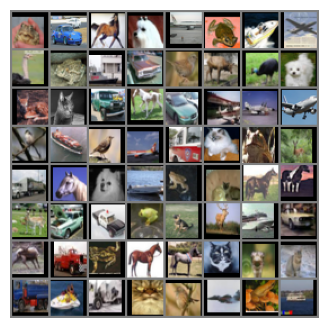

Labels: frog  car   horse dog  


In [73]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## 2b. Model Architecture

We'll implement a Convolutional Neural Network (CNN) with the following structure:

1. Three convolutional blocks, each consisting of:
   - Convolutional layer
   - Batch normalisation
   - ReLU activation
   - Max pooling
2. Three fully connected layers for classification

Justification:
- Convolutional layers: effective for capturing spatial patterns in images
- Batch normalisation: helpss with training stability and reduces internal covariate shift
- Max pooling: Reduces spatial dimensions while retaining important features
- Multiple conv blocks: allows hierarchical feature learning
- ReLU activation: helps with vanishing gradient problem and introduces non-linearity

In [74]:
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        # first conv block
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 32x32x32
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # 16x16x32

        # second conv block
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 16x16x64
        self.bn2 = nn.BatchNorm2d(64)  # 8x8x64

        # third conv block
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 8x8x128
        self.bn3 = nn.BatchNorm2d(128)  # 4x4x128

        # fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # first block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # third block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [75]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
model = CIFAR10CNN().to(device)

model

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [76]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=0.001) # ysing adamw due to better suited 1e-2 decay coefficient

print('\ntrainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))


trainable parameters: 1209738


In [77]:
def train(model, trainloader, criterion, optimizer, n_epochs, device):
    # metrci tracking
    train_losses = []
    train_accuracies = []
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # training loop
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # zero grads
            optimizer.zero_grad()
            
            # forrward + backward + optim
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # stats
            running_loss += loss.item()
            
            if i % 100 == 99:
                print(f'[epoch {epoch + 1}, batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        
        # calc epoch metrics
        epoch_accuracy = 100 * correct / total
        epoch_loss = running_loss / len(trainloader)
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'epoch {epoch + 1} completed.')
        print(f'accuracy: {epoch_accuracy:.2f}%')
        print('-' * 40)
    
    return train_losses, train_accuracies

def plot_training_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(15, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Base model training

In [78]:
n_epochs = 2
train_losses, train_accuracies = train(model, trainloader, criterion, optimiser, n_epochs, device)

[epoch 1, batch 100] loss: 1.961
[epoch 1, batch 200] loss: 1.703
[epoch 1, batch 300] loss: 1.563
[epoch 1, batch 400] loss: 1.500
[epoch 1, batch 500] loss: 1.451
[epoch 1, batch 600] loss: 1.366
[epoch 1, batch 700] loss: 1.331
epoch 1 completed.
accuracy: 43.63%
----------------------------------------
[epoch 2, batch 100] loss: 1.260
[epoch 2, batch 200] loss: 1.229
[epoch 2, batch 300] loss: 1.205
[epoch 2, batch 400] loss: 1.139
[epoch 2, batch 500] loss: 1.171
[epoch 2, batch 600] loss: 1.155
[epoch 2, batch 700] loss: 1.097
epoch 2 completed.
accuracy: 58.14%
----------------------------------------


[0.13605150618516576, 0.11538947688039307] [43.63, 58.144]


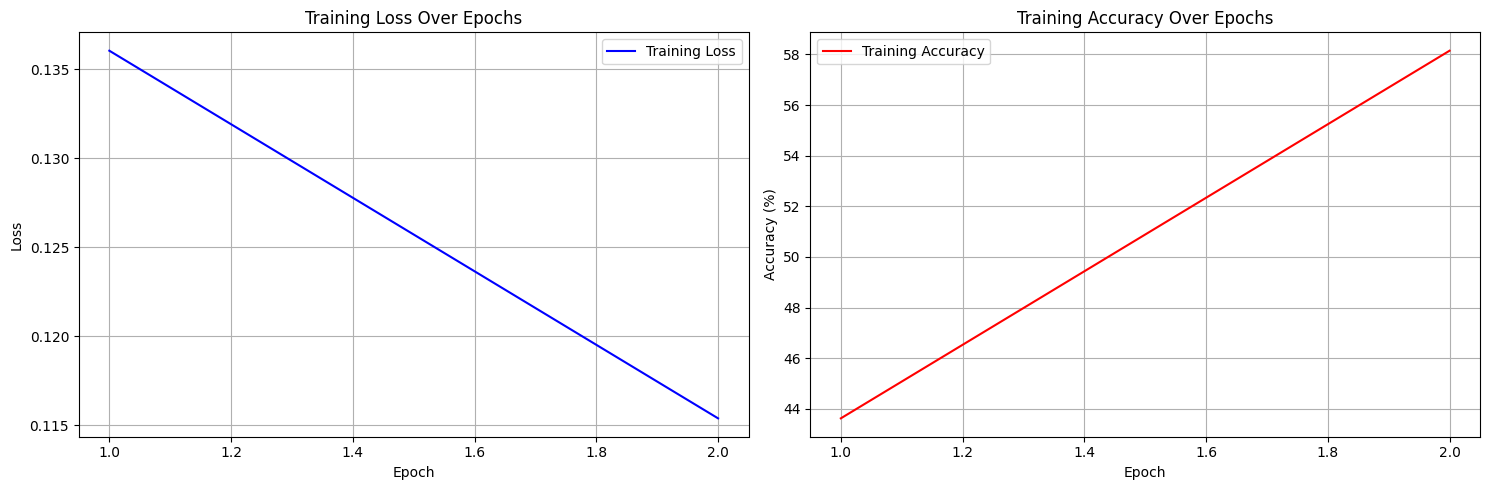

In [79]:
print(train_losses, train_accuracies)
plot_training_metrics(train_losses, train_accuracies)

In [80]:
def evaluate_base(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # print overall accuracy
    print(f'overall accuracy on test set: {100 * correct / total:.2f}%')
    
    # print class accuracy
    print('\nclasss accuracy:')
    for i in range(10):
        print(f'{classes[i]:>10s}: {100 * class_correct[i] / class_total[i]:.2f}%')

In [81]:
evaluate_base(model, testloader, device)

overall accuracy on test set: 61.31%

classs accuracy:
     plane: 72.00%
       car: 83.20%
      bird: 27.60%
       cat: 46.00%
      deer: 66.40%
       dog: 45.10%
      frog: 35.30%
     horse: 78.70%
      ship: 84.20%
     truck: 74.60%


## Model hyperparameter optimization

In [82]:
import os
from torch import optim
from itertools import product

param_grid = {
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [1e-4, 1e-2],
    'dropout': [0.25, 0.5],
    'batch_size': [32, 64]
}

param_combinations = list(product(param_grid['learning_rate'],
                                   param_grid['weight_decay'],
                                   param_grid['dropout'],
                                   param_grid['batch_size']))

results = []
csv_file= 'hyperparameter_tuning_results.csv'

def evaluate_grid_search(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss / len(dataloader):.3f}')
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

def grid_search(criterion, device, param_combinations):
    for lr, wd, dropout_rate, batch_size in param_combinations:
        print(f'Training with lr={lr}, weight_decay={wd}, dropout={dropout_rate}, batch_size={batch_size}')

        model = CIFAR10CNN()
        model.dropout.p = dropout_rate
        model.to(device)

        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        train_losses = train(model, trainloader, criterion, optimizer, n_epochs=2, device=device)

        val_accuracy = evaluate_grid_search(model, testloader, criterion, device)

        results.append({'lr': lr, 'weight_decay': wd, 'dropout': dropout_rate, 'batch_size': batch_size,
                        'val_accuracy': val_accuracy})

        print(f'Val accuracy: {val_accuracy:.2f}%\n')

    best_config = max(results, key=lambda x: x['val_accuracy'])
    print(f'Best config: {best_config}')
    df_results = pd.DataFrame(results)

    df_results.to_csv(csv_file, index=False)

    print('Results saved to hyperparameter_tuning_results.csv')
    print(df_results.sort_values(by='val_accuracy', ascending=False).head())

def load_best_hyperparameters(criterion, device, param_grid):
    if os.path.exists(csv_file):
        print(f'Found existing CSV: {csv_file}. Loading best hyperparameters...')
        df_results = pd.read_csv(csv_file)
        best_config = df_results.loc[df_results['val_accuracy'].idxmax()]

        print(f'Best parameters loaded: lr={best_config['lr']}, weight_decay={best_config['weight_decay']}, '
              f'dropout={best_config['dropout']}, batch_size={best_config['batch_size']}')
        return best_config
    else:
        grid_search(criterion, device, param_grid)
        load_best_hyperparameters(criterion, device, param_grid)
best_config = load_best_hyperparameters(criterion, device, param_grid)


Found existing CSV: hyperparameter_tuning_results.csv. Loading best hyperparameters...
Best parameters loaded: lr=0.001, weight_decay=0.0001, dropout=0.25, batch_size=32.0


In [ ]:
def train_with_best_config(model, trainloader, criterion, optimizer, n_epochs, device, dropout_rate):
    # metrci tracking
    train_losses = []
    train_accuracies = []

    # Update model dropout rate
    model.dropout = nn.Dropout(dropout_rate)

    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # training loop
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero grads
            optimizer.zero_grad()

            # forward + backward + optim
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # stats
            running_loss += loss.item()

            if i % 100 == 99:
                print(f'[epoch {epoch + 1}, batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        # calc epoch metrics
        epoch_accuracy = 100 * correct / total
        epoch_loss = running_loss / len(trainloader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'epoch {epoch + 1} completed.')
        print(f'accuracy: {epoch_accuracy:.2f}%')
        print('-' * 40)

    return train_losses, train_accuracies


batch_size = best_config['batch_size']
weight_decay = best_config['weight_decay']
dropout_rate = best_config['dropout']
n_epochs = 2

model = CIFAR10CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=best_config['lr'], weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=int(batch_size), shuffle=True, num_workers=2)



train_losses, train_accuracies = train_with_best_config(model, trainloader, criterion, optimizer, n_epochs, device, dropout_rate)


plot_training_metrics(train_losses, train_accuracies)
